<a href="https://colab.research.google.com/github/AdriaDelhom/CGM/blob/main/GoodResults.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/CGM/data')

Mounted at /content/drive


In [ ]:
ACC_HZ = 32
ACC_G_MODE = 2
SMALL_G = 9.81

## Loading in some data

In [ ]:
food = pd.read_csv('./001/Food_Log_001.csv', index_col=['time_begin'], parse_dates=['time_begin'], skipinitialspace=True)

In [ ]:
glu = pd.read_csv('./001/Dexcom_001.csv', header=0, skiprows=range(1, 13), index_col=['Timestamp (YYYY-MM-DDThh:mm:ss)'], parse_dates=['Timestamp (YYYY-MM-DDThh:mm:ss)'])

In [ ]:
food5 = pd.read_csv('./005/Food_Log_005.csv', index_col=['time_begin'], parse_dates=['time_begin'], skipinitialspace=True)
glu5 = pd.read_csv('./005/Dexcom_005.csv', header=0, skiprows=range(1, 13), index_col=['Timestamp (YYYY-MM-DDThh:mm:ss)'], parse_dates=['Timestamp (YYYY-MM-DDThh:mm:ss)'])

### Data Notes
- Patient 003 food log has no headers

In [ ]:
# Plot the series with food consumption marked
def plot_series_with_food(series, food, time_start, time_end):
  series_slice = series.loc[time_start:time_end, 'Glucose Value (mg/dL)']
  series_slice_range = series_slice.max() - series_slice.min()
  series_slice_mid = (series_slice.max() + series_slice.min()) / 2
  food_slice = food[(time_start <= food.index) & (food.index <= pd.Timestamp(time_end) + pd.Timedelta(days=1))]

  ymin = series_slice_mid - series_slice_range * 0.6
  ymax = series_slice_mid + series_slice_range * 0.6

  plt.figure(figsize=(20, 4))
  plt.plot(series_slice)
  plt.vlines(food_slice.index, ymin=ymin, ymax=ymax, colors='red')

## Exmaple Glucose vs Food Consumption
The last day charts show the period with no food consumption followed by Boost

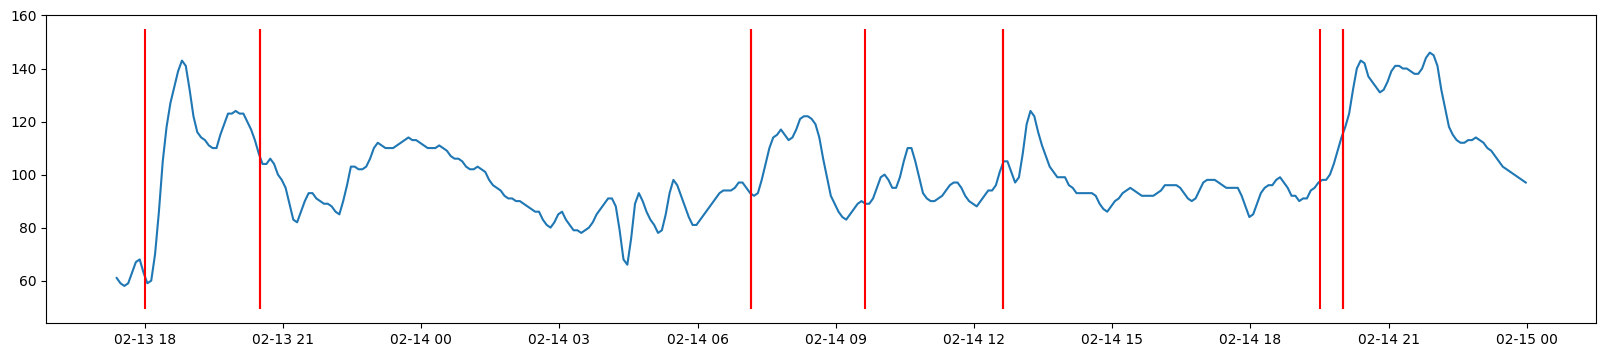

In [ ]:
plot_series_with_food(glu, food, '2020-02-13', '2020-02-14')

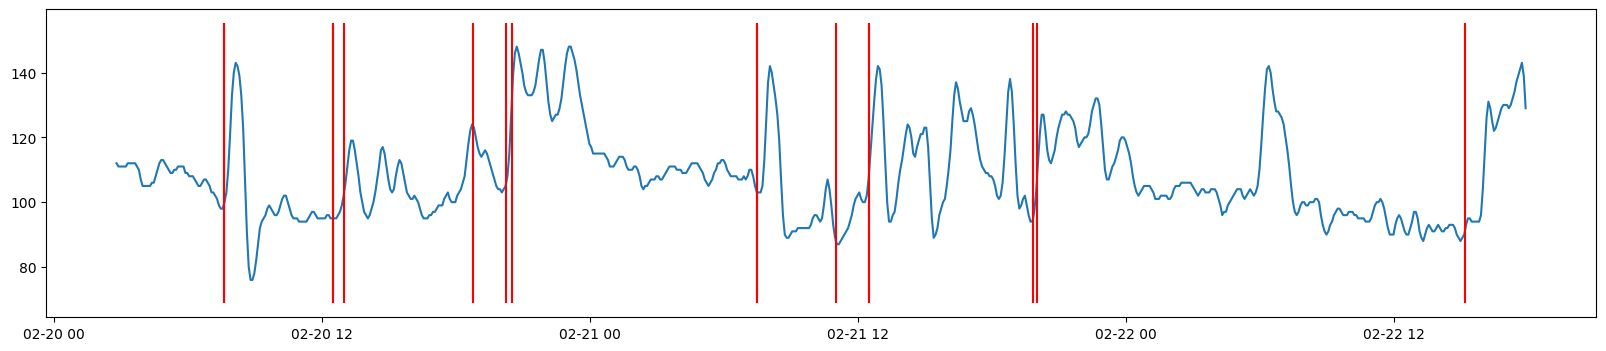

In [ ]:
plot_series_with_food(glu, food, '2020-02-20', '2020-02-22')

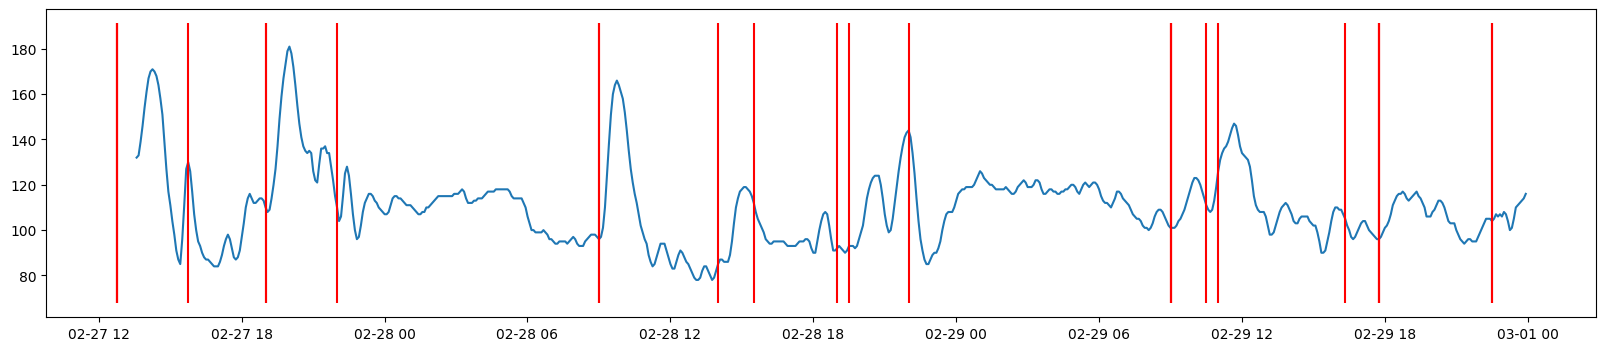

In [ ]:
plot_series_with_food(glu5, food5, '2020-02-27', '2020-02-29')

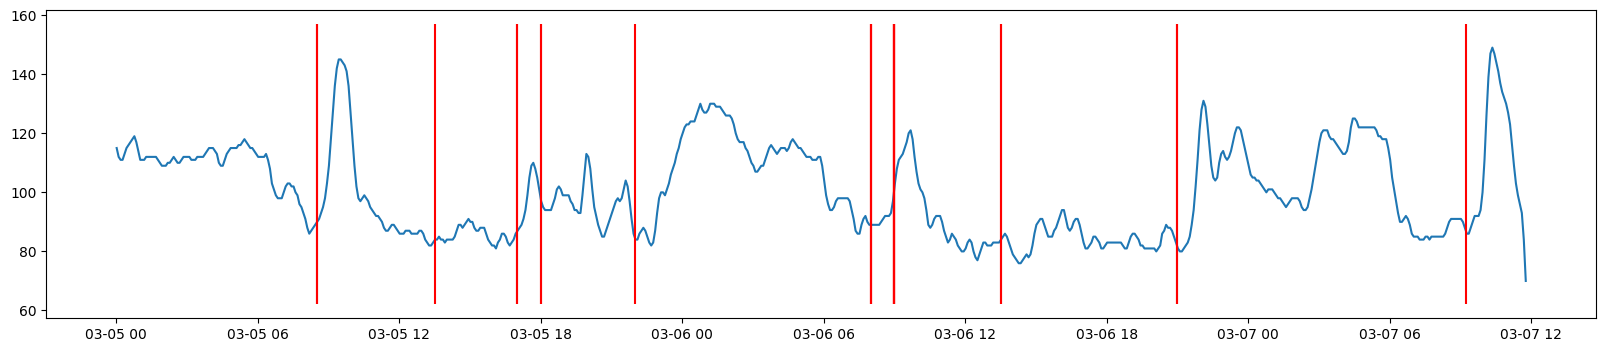

In [ ]:
plot_series_with_food(glu5, food5, '2020-03-05', '2020-03-07')

In [ ]:
class Patient:

  metric_map = {
      'acc': 'ACC',
      'bvp': 'BVP',
      'glu': 'Dexcom',
      'eda': 'EDA',
      'food': 'Food_Log',
      'hr': 'HR',
      'ibi': 'IBI',
      'temp': 'TEMP'
  }

  def __init__(self, patient_id, gender, hba1c) -> None:
    self.patient_id: int = patient_id
    self.gender: str = gender
    self.hba1c: float = hba1c

    self._acc: pd.DataFrame = None
    self._bvp: pd.DataFrame = None
    self._glu: pd.DataFrame = None
    self._eda: pd.DataFrame = None
    self._food: pd.DataFrame = None
    self._hr: pd.DataFrame = None
    self._ibi: pd.DataFrame = None
    self._temp: pd.DataFrame = None


  def get_file_path(self, metric):
    metric_name = Patient.metric_map[metric]
    return f'./{self.patient_id:03d}/{metric_name}_{self.patient_id:03d}.csv'

  @property
  def acc(self):
    if self._acc is None:
      self._acc = pd.read_csv(self.get_file_path('acc'), index_col=['datetime'],
                              parse_dates=['datetime'], engine='pyarrow')
      self._acc.columns = [c.strip() for c in self._acc.columns]
      # Convert all columns to m/s^2 from int8 in 2G mode
      # TODO It is possible that values <0 should be divided by 128 and > 0 by 127
      self._acc['acc_x'] = (self._acc['acc_x'] * ACC_G_MODE * SMALL_G) / 127
      self._acc['acc_y'] = (self._acc['acc_y'] * ACC_G_MODE * SMALL_G) / 127
      self._acc['acc_z'] = (self._acc['acc_z'] * ACC_G_MODE * SMALL_G) / 127
    return self._acc

  @property
  def bvp(self):
    if self._bvp is None:
      self._bvp = pd.read_csv(self.get_file_path('bvp'), index_col=['datetime'],
                              parse_dates=['datetime'], engine='pyarrow')
      self._bvp.columns = [c.strip() for c in self._bvp.columns]
    return self._bvp


  @property
  def glu(self):
    if self._glu is None:
      self._glu = pd.read_csv(self.get_file_path('glu'), header=0,
                              skiprows=range(1, 13),
                              index_col=['Timestamp (YYYY-MM-DDThh:mm:ss)'],
                              parse_dates=['Timestamp (YYYY-MM-DDThh:mm:ss)'])
      self._glu = self._glu.rename(columns={'Glucose Value (mg/dL)': 'glucose'})
      self._glu = self._glu.rename_axis('datetime')
      self._glu = self._glu[['glucose']]
    return self._glu

  @property
  def eda(self):
    if self._eda is None:
      self._eda = pd.read_csv(self.get_file_path('eda'), index_col=['datetime'],
                              parse_dates=['datetime'], engine='pyarrow')
      self._eda.columns = [c.strip() for c in self._eda.columns]
    return self._eda

  @property
  def food(self):
    if self._food is None:
      if self.patient_id == 3:
        # Patient 3 has no header
        self._food = pd.read_csv(self.get_file_path('food'), skipinitialspace=True)
        self._food.columns = ['date', 'time', 'time_begin', 'logged_food', 'amount', 'unit', 'searched_food', 'calorie', 'total_carb', 'sugar', 'protein']
        self._food['time_begin'] = pd.to_datetime(self._food['time_begin'])
        self._food['time_end'] = None
        self._food = self._food.set_index('time_begin')
      else:
        self._food = pd.read_csv(self.get_file_path('food'), index_col=['time_begin'], parse_dates=['time_begin'], skipinitialspace=True)

      self._food['time_end'] = pd.to_datetime(self._food['date'] + ' ' + self._food['time_end'])

      end_times = self._food.groupby('time_begin')['time_end'].min()
      self._food = self._food.merge(end_times, how='left', on='time_begin', suffixes=('','_x'), validate='many_to_one')
      self._food['time_end'] = self._food['time_end'].fillna(self._food['time_end_x'])
      self._food = self._food.drop('time_end_x', axis=1)

      # Fill in NaN in searched food with empty string
      self._food['searched_food'] = self._food['searched_food'].fillna('')

      # Some food logs have `time_of_day` instead of `time`
      if self.patient_id in [7, 13, 15, 16]:
        self._food = self._food.drop(['date', 'time_of_day'], axis=1)
      else:
        self._food = self._food.drop(['date', 'time'], axis=1)
    return self._food

  @property
  def hr(self):
    if self._hr is None:
      # Patient 1 has no seconds recorded
      if self.patient_id == 1:
        self._hr = pd.read_csv('./001/HR_001.csv',
                              parse_dates=['datetime'],
                              date_format='%m/%d/%y %H:%M',
                              engine='pyarrow')
        self._hr.loc[self._hr.groupby('datetime').cumcount() + 1 != 1, 'datetime'] = pd.NaT
        self._hr = self._hr.interpolate(method='linear')
        self._hr = self._hr.set_index('datetime')
      else:
        self._hr = pd.read_csv(self.get_file_path('hr'), index_col=['datetime'],
                              parse_dates=['datetime'], engine='pyarrow')
      self._hr.columns = [c.strip() for c in self._hr.columns]

    return self._hr

  @property
  def ibi(self):
    if self._ibi is None:
      self._ibi = pd.read_csv(self.get_file_path('ibi'), index_col=['datetime'],
                              parse_dates=['datetime'], engine='pyarrow')
      self._ibi.columns = [c.strip() for c in self._ibi.columns]
    return self._ibi

  @property
  def temp(self):
    if self._temp is None:
      self._temp = pd.read_csv(self.get_file_path('temp'), index_col=['datetime'],
                              parse_dates=['datetime'], engine='pyarrow')
      self._temp.columns = [c.strip() for c in self._temp.columns]
    return self._temp

class CGMData:
  patients: Patient = {}
  demographics: pd.DataFrame = None

  def __init__(self) -> None:
    self.demographics = pd.read_csv('./Demographics.csv', index_col='ID')

  def __getitem__(self, key):
    if key < 1 or key > 16:
      raise IndexError(f'Patient ID {key} out of range')
    if key not in self.patients:
      patient_demo = self.demographics.loc[key]
      self.patients[key] = Patient(key, patient_demo['Gender'], patient_demo['HbA1c'])
    return self.patients[key]

In [ ]:
data = CGMData()
print(data[1].gender)
print(data[1].hba1c)
# print(data[1].glu.head(5))

FEMALE
5.5


In [ ]:
data[6].food['searched_food']

time_begin
2020-02-28 08:10:00     
2020-02-28 09:15:00     
2020-02-28 11:25:00     
2020-02-28 15:30:00     
2020-02-28 19:30:00     
                      ..
2020-03-08 12:30:00     
2020-03-08 12:30:00     
2020-03-08 19:50:00     
2020-03-08 19:50:00     
2020-03-09 07:30:00     
Name: searched_food, Length: 73, dtype: object

In [ ]:
# Verifying all datasets load properly
for i in range(2, 3):
  for data_str in ['acc', 'bvp', 'glu', 'eda', 'food', 'hr', 'ibi', 'temp']:
    print(i, data_str)
    try:
      print(data[i].__getattribute__(data_str).head(5))
    except Exception as e:
      print(f"Error on patient {i} with {data_str}: {e}")

2 acc
                               acc_x     acc_y     acc_z
datetime                                                
2020-02-21 09:19:06.000000 -1.544882 -5.407087  8.033386
2020-02-21 09:19:06.031250 -1.544882 -5.407087  7.878898
2020-02-21 09:19:06.062500 -1.544882 -5.407087  7.878898
2020-02-21 09:19:06.093750 -1.544882 -5.407087  7.878898
2020-02-21 09:19:06.125000 -1.544882 -5.407087  7.878898
2 bvp
                            bvp
datetime                       
2020-02-21 09:19:06.000000 -0.0
2020-02-21 09:19:06.015625 -0.0
2020-02-21 09:19:06.031250 -0.0
2020-02-21 09:19:06.046875 -0.0
2020-02-21 09:19:06.062500 -0.0
2 glu
                     glucose
datetime                    
2020-02-21 11:08:36    186.0
2020-02-21 11:13:36    181.0
2020-02-21 11:18:36    175.0
2020-02-21 11:23:35    168.0
2020-02-21 11:28:36    163.0
2 eda
                              eda
datetime                         
2020-02-21 09:19:06.000  0.000000
2020-02-21 09:19:06.250  0.139648
2020-02-21 09:

## Look at post meal glucose response ofr single patient

In [ ]:
# Get the curve immediately after food consumption
def get_meal_spike(glu, time, duration):
  # get a slice of glu for duration hours after time
  glu_slice = glu.loc[time:time + pd.Timedelta(hours=duration), 'glucose']
  glu_slice.index = glu_slice.index - glu_slice.index[0]
  # sometimes the measurements are off by a second
  glu_slice.index = glu_slice.index.round(freq='5min')
  return glu_slice

In [ ]:
slices = []
for start in food.index:
  slices.append(get_meal_spike(data[1].glu, start, 3))

In [ ]:
# TODO Only include spike with a single food item and not consumed iwthin 3 hours of other food items

In [ ]:
# Meals from patient 1, start aligned
plt.figure(figsize=(20, 4))
for col in range(df.shape[1]):
  plt.plot(df[col] - df.iloc[0, col], color='blue', alpha=0.2)

NameError: name 'df' is not defined

<Figure size 2000x400 with 0 Axes>

In [ ]:
df.iloc[0, 0]

59.0

In [ ]:
def find_standard_meal(df):
  bfast_filter = df['searched_food'].str.contains('Partly Skimmed Milk') | df['searched_food'].str.contains('Frosted Flakes')
  return df[bfast_filter]

In [ ]:
find_standard_meal(data[3].food)

,date,time,time_begin,logged_food,amount,unit,searched_food,calorie,total_carb,sugar,protein
6,2020-02-23,05:30:00,2020-02-23 05:30:00,Milk,4.0,ounce,(Natrel) Lactose Free 2% Partly Skimmed Milk,60.0,4.5,4.0,6.0
7,2020-02-23,05:30:00,2020-02-23 05:30:00,Cornflakes,1.5,cup,(Kellogg's) Frosted Flakes,220.0,52.0,20.0,2.0
22,2020-02-25,06:50:00,2020-02-25 06:50:00,Milk,4.0,ounce,(Natrel) Lactose Free 2% Partly Skimmed Milk,60.0,4.5,4.0,6.0
23,2020-02-25,06:50:00,2020-02-25 06:50:00,Cornflakes,1.5,cup,(Kellogg's) Frosted Flakes,220.0,52.0,20.0,2.0
40,2020-02-27,05:30:00,2020-02-27 05:30:00,Milk,4.0,ounce,(Natrel) Lactose Free 2% Partly Skimmed Milk,60.0,4.5,4.0,6.0
41,2020-02-27,05:30:00,2020-02-27 05:30:00,Cornflakes,1.5,cup,(Kellogg's) Frosted Flakes,220.0,52.0,20.0,2.0
51,2020-02-29,08:15:00,2020-02-29 08:15:00,Milk,4.0,ounce,(Natrel) Lactose Free 2% Partly Skimmed Milk,60.0,4.5,4.0,6.0
52,2020-02-29,08:15:00,2020-02-29 08:15:00,Cornflakes,1.5,cup,(Kellogg's) Frosted Flakes,220.0,52.0,20.0,2.0


In [ ]:
data[3].food[data[3].food['searched_food'].str.contains('Partly Skimmed Milk') | data[3].food['searched_food'].str.contains('Frosted Flakes')]

,date,time,time_begin,logged_food,amount,unit,searched_food,calorie,total_carb,sugar,protein
6,2020-02-23,05:30:00,2020-02-23 05:30:00,Milk,4.0,ounce,(Natrel) Lactose Free 2% Partly Skimmed Milk,60.0,4.5,4.0,6.0
7,2020-02-23,05:30:00,2020-02-23 05:30:00,Cornflakes,1.5,cup,(Kellogg's) Frosted Flakes,220.0,52.0,20.0,2.0
22,2020-02-25,06:50:00,2020-02-25 06:50:00,Milk,4.0,ounce,(Natrel) Lactose Free 2% Partly Skimmed Milk,60.0,4.5,4.0,6.0
23,2020-02-25,06:50:00,2020-02-25 06:50:00,Cornflakes,1.5,cup,(Kellogg's) Frosted Flakes,220.0,52.0,20.0,2.0
40,2020-02-27,05:30:00,2020-02-27 05:30:00,Milk,4.0,ounce,(Natrel) Lactose Free 2% Partly Skimmed Milk,60.0,4.5,4.0,6.0
41,2020-02-27,05:30:00,2020-02-27 05:30:00,Cornflakes,1.5,cup,(Kellogg's) Frosted Flakes,220.0,52.0,20.0,2.0
51,2020-02-29,08:15:00,2020-02-29 08:15:00,Milk,4.0,ounce,(Natrel) Lactose Free 2% Partly Skimmed Milk,60.0,4.5,4.0,6.0
52,2020-02-29,08:15:00,2020-02-29 08:15:00,Cornflakes,1.5,cup,(Kellogg's) Frosted Flakes,220.0,52.0,20.0,2.0


In [ ]:
data[2].food.head()

,time_end,logged_food,amount,unit,searched_food,calorie,total_carb,dietary_fiber,sugar,protein,total_fat
time_begin,,,,,,,,,,,
2020-02-21 10:09:00,NaT,Mello Yello,12.0,fluid ounce,Mello Yello,180.0,48.0,0.0,48.0,0.0,0.0
2020-02-21 10:11:00,NaT,(Jimmy Dean) Chicken Biscuit,1.0,NaN,"(Jimmy Dean) Sandwiches, Biscuit Southern Styl...",280.0,32.0,2.0,3.0,13.0,12.0
2020-02-21 12:09:00,NaT,Beef Jerky,2.0,NaN,Large Beef Jerky,164.0,4.4,0.7,3.6,13.0,10.0
2020-02-21 12:12:00,NaT,(Gatorade) Fierce Grape,12.0,fluid ounce,Gatorade Fierce Grape,84.0,21.6,NaN,20.4,0.0,NaN
2020-02-21 14:02:00,NaT,Banquet Chicken Pot Pie,198.0,gram,Banquet Chicken Pot Pie,700.0,66.0,NaN,4.0,24.0,NaN


In [ ]:
# Collect standard breakfasts
std_curves = []
for i in range(1, 14):
  std_meal = find_standard_meal(data[i].food)
  if std_meal.empty:
    continue

  meal_times = std_meal.index.unique()
  for time in meal_times:
    std_curves.append(get_meal_spike(data[i].glu, time, 3))
std_curves = pd.concat(std_curves, axis=1)
std_curves.columns = list(range(std_curves.shape[1]))

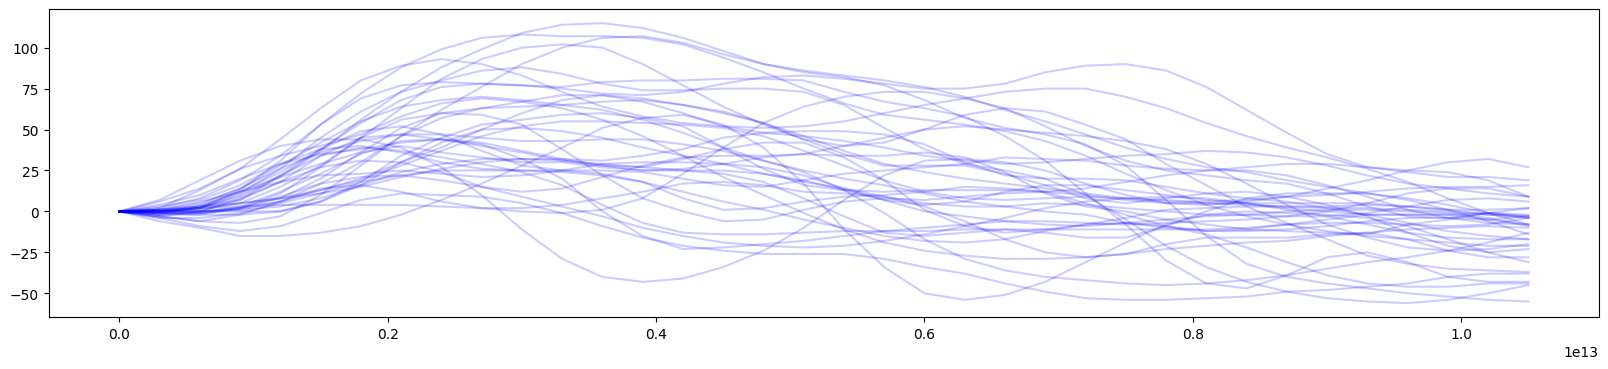

In [ ]:
# Standard breakfast responses, start aligned
plt.figure(figsize=(20, 4))
for col in range(std_curves.shape[1]):
  plt.plot(std_curves[col] - std_curves.iloc[0, col], color='blue', alpha=0.2)

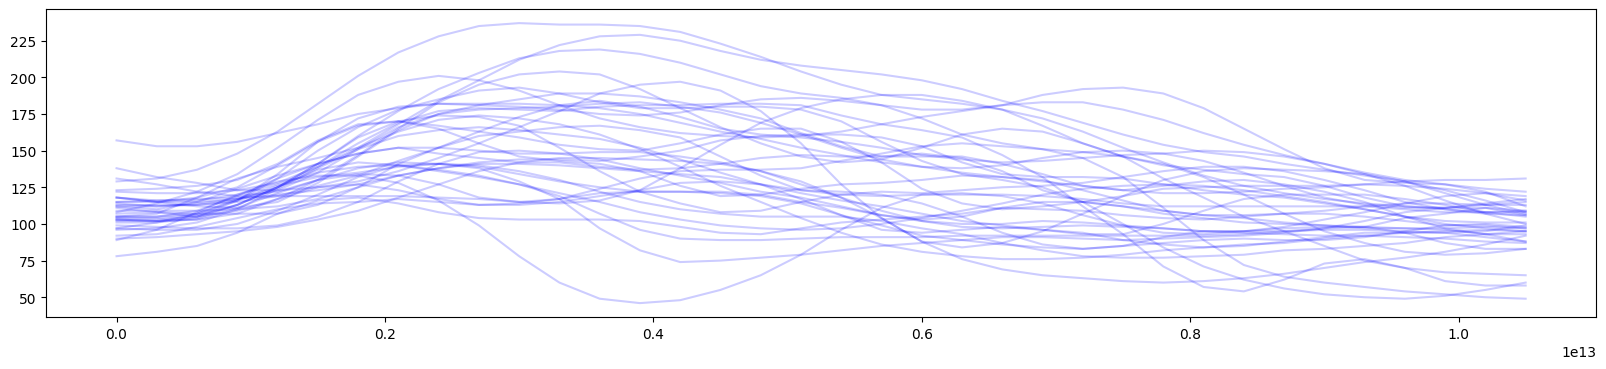

In [ ]:
# Standard breakfast responses
plt.figure(figsize=(20, 4))
for col in range(std_curves.shape[1]):
  plt.plot(std_curves[col], color='blue', alpha=0.2)

## Possible compression lows in patient 1 when the the redd acc line is higher
According to the empatica E4 documentation the z-axis (**red** line), is upwards from the "watch face". If the patient is lying on their back, then we would expect a strong negative z-axis signal if their wrist is flat or a strong x-axis (likely **orange**) signal if their wrist is rotated. y-axis (likely **green**) signal should be minimal.
If the patient is lying on their stomach, the we should expect a strong, positive z-axis signal,

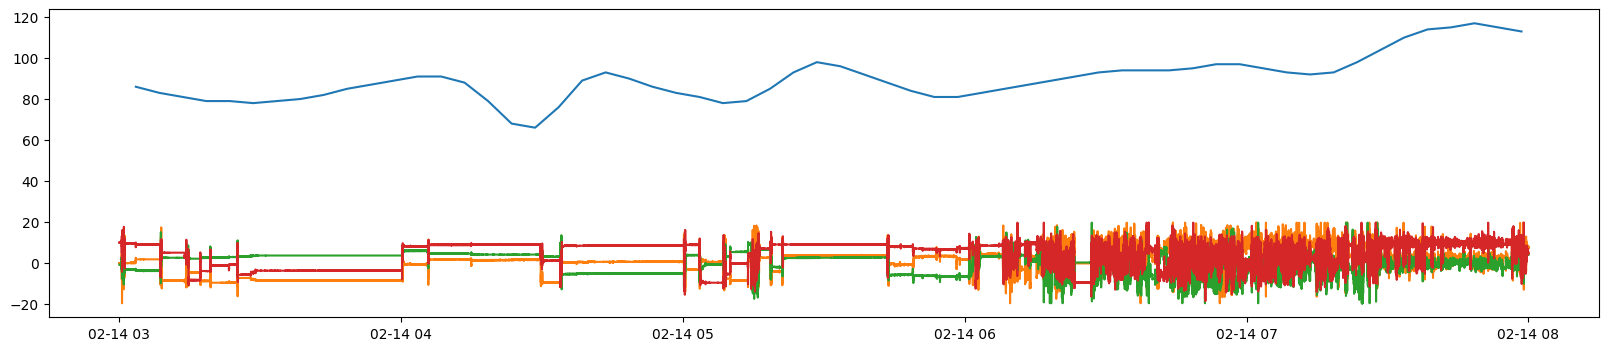

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(data[1].glu[(data[1].glu.index < '2020-02-14 08:00:00') & (data[1].glu.index > '2020-02-14 03:00:00')])
plt.plot(data[1].acc[(data[1].acc.index < '2020-02-14 08:00:00') & (data[1].acc.index > '2020-02-14 03:00:00')])

In [ ]:
# Here x and z are negative, potentially indicating the right wrist is rotated slightly counterclockwise, while the patient lying on their back
data[1].acc[(data[1].acc.index < '2020-02-14 03:55:00') & (data[1].acc.index > '2020-02-14 03:54:00')].head()

,acc_x,acc_y,acc_z
datetime,,,
2020-02-14 03:54:00.031250,-8.496850,3.553228,-3.862205
2020-02-14 03:54:00.062500,-8.651339,3.553228,-3.862205
2020-02-14 03:54:00.093750,-8.496850,3.553228,-3.862205
2020-02-14 03:54:00.125000,-8.496850,3.553228,-3.862205
2020-02-14 03:54:00.156250,-8.651339,3.553228,-3.862205


In [ ]:
# z is positive, potentially showing the patient lying on their stomach
# Not sure what is causing y to be negative, arm is likely at an odd angle, wrist parallel to ground
data[1].acc[(data[1].acc.index < '2020-02-14 04:40:00') & (data[1].acc.index > '2020-02-14 04:39:00')].head()

,acc_x,acc_y,acc_z
datetime,,,
2020-02-14 04:39:00.031250,0.308976,-5.252598,8.342362
2020-02-14 04:39:00.062500,0.308976,-5.252598,8.342362
2020-02-14 04:39:00.093750,0.308976,-5.252598,8.342362
2020-02-14 04:39:00.125000,0.308976,-5.252598,8.342362
2020-02-14 04:39:00.156250,0.308976,-5.252598,8.342362


## Simple time series fit to glu curve on patient 1